# EasySkim

In [186]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Get data

This is a replication of the paper PubMed 200k RCT, download the dataset they used.The data set is available on [github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [187]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [188]:
# Check what files are there in PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [189]:
# Start our experiment using the 20k dataset with numbers replaced by '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [190]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

Now that we've got our data, let's write a function to read in all of the lines of a target text file.

In [191]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as list.

  Args:
    filename: a string containing the target filepath
  
  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [192]:
# Read in the training text
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

This is how we should make our to be (give it some structure)

```
[{'line_number' : 0,
  'target' : 'BACKGROUNG',
  'text' : 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines' : 11},
  ...]
```

In [193]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in filename, reads it's contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many lines are there in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # Get all lines from the filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith('###'): # check to see if it's the start of an abstract
      abstract_id = line
      abstract_lines = '' # reset the abstract string if the line belongs to new abstract
    elif line.isspace(): # check to see if it's new line
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstractand count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
  
  return abstract_samples

In [194]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [195]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that we have the data in a more structured format, let's visualize the data using a DataFrame

In [196]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [197]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [198]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

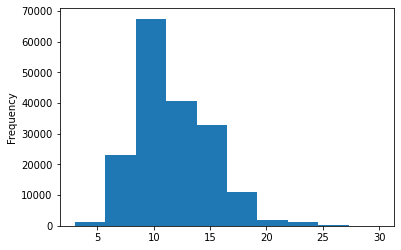

In [199]:
# Check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [200]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [201]:
# View 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numerical labels

In [202]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encoding

In [203]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [204]:
# Get class names and  number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [206]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [207]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)

In [208]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-27 17:38:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-27 17:38:52 (85.3 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [209]:
from helper_functions import calculate_results

In [210]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) fro deep sequence models

Before we start buliding deeper models, we've got to create vectorization and embedding layers.

In [211]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

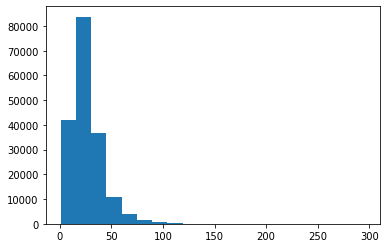

In [212]:
# What does the distribution of the length of the sentences look like?
plt.hist(sent_lens, bins=20);

In [213]:
# How long is sentence in 95th percentile?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorization layer

We want to make a layer that maps our texts from words to numbers

In [214]:
# Vocab size (from paper)
max_tokens = 68000

In [215]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [216]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [217]:
# Test out the text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
in acute pain following third molar extraction , faster acting analgesic formulations provide earlier onset of pain relief , better overall pain relief and a less frequent need for additional analgesia , indicating longer lasting pain relief .

Length of text: 38

Vectorized text: [[   5  229   65  240  990 3562 2671 1428 5782  950 2053  414 1448  779
     4   65 1128  252  188   65 1128    3    8  211  938  483   11  365
   673 1401  583 2953   65 1128    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [218]:
# How many words in our vocabulary
rtc_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocab: {len(rtc_20k_text_vocab)}')
print(f'Most common words: {rtc_20k_text_vocab[:5]}')
print(f'Least common words: {rtc_20k_text_vocab[-5:]}')

Number of words in the vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create custom text embedding

In [219]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rtc_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

In [220]:
# Example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n {vectorized_sentence}')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Shape of embedded sentence:\n {embedded_sentence.shape}')

Sentence before vectorization:
 in acute pain following third molar extraction , faster acting analgesic formulations provide earlier onset of pain relief , better overall pain relief and a less frequent need for additional analgesia , indicating longer lasting pain relief .

Sentence after vectorization:
 [[   5  229   65  240  990 3562 2671 1428 5782  950 2053  414 1448  779
     4   65 1128  252  188   65 1128    3    8  211  938  483   11  365
   673 1401  583 2953   65 1128    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding:
 [[[-0.02500819  0.0177493  -0.03886939 ...  0.03905429  0.00685644
   -0.03684852]
  [-0.01018811  0.02361654  0.02224151 ... -0.03832898 -0.04674302
    0.02531625]
  [ 0.0348845  -0.03110018  0.04980895 ... -0.01211524 -0.03404703
    0.00182705]
  ...
  [-0.0117316  -0.03527341 -0.00118404 ...  0.00194187  0.0118497
    0.00848123]
  [-0.0117316  -0.03527341 -0.00118404 ... 

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup up our data to run as fast as possible with the TensorFlow tf.data.API

In [221]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [222]:
# Take the TensorSliceDatasets and turn them intp prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [223]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu') (token_embeddings)
x = layers.GlobalAveragePooling1D() (x)
outputs = layers.Dense(num_classes, activation='softmax') (x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_1.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 5)                 325

In [224]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9096 - accuracy: 0.6437 - val_loss: 0.6851 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6615 - accuracy: 0.7552 - val_loss: 0.6362 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6220 - accuracy: 0.7725 - val_loss: 0.6002 - val_accuracy: 0.7826


In [225]:
# Evaluate in whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6038 - accuracy: 0.7848


[0.6038100719451904, 0.7847543954849243]

In [226]:
# Make predictions 
model_1_pred_probs = model_1.predict(val_dataset)

945/945 [==============================] - 2s 2ms/step


In [227]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [228]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.47544022242818,
 'precision': 0.7815852504955074,
 'recall': 0.7847544022242817,
 'f1': 0.782558922985788}

In [229]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically [the universal sentence encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

The paper originally usese GloVe embeddings, however we're going to stick with the later created USE pretrained embeddings.

In [230]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [231]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random Sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding: \n {use_embedded_sentence[0][:30]}\n')
print(f'Lenght of sentence embedding: {len(use_embedded_sentence[0])}')

Random Sentence:
 egfr immunohistochemistry ( ihc ) , fluorescent in situ hybridization ( fish ) , and mutation analyses were performed in @ patients .
Sentence after embedding: 
 [ 0.03443561  0.06418788 -0.0307926  -0.01907516  0.01511577  0.01870417
 -0.00147026  0.01914056 -0.05529007 -0.02622727  0.0844297   0.00088814
  0.07132515  0.06797303  0.05522575 -0.07453601 -0.06702262  0.01059551
  0.06320653  0.01995812 -0.01787183  0.03110645 -0.0555139  -0.00176879
  0.0632507  -0.03525687  0.08183769  0.00736379  0.05309163  0.06490785]

Lenght of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [232]:
# Define feature extraction model using TF hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [233]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dense_20 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [234]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.2 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.2 * len(val_dataset)))

Epoch 1/3
1125/1125 [==============================] - 19s 15ms/step - loss: 0.8432 - accuracy: 0.6758 - val_loss: 0.7547 - val_accuracy: 0.7083
Epoch 2/3
1125/1125 [==============================] - 16s 14ms/step - loss: 0.7370 - accuracy: 0.7179 - val_loss: 0.7157 - val_accuracy: 0.7300
Epoch 3/3
1125/1125 [==============================] - 16s 14ms/step - loss: 0.7239 - accuracy: 0.7234 - val_loss: 0.6825 - val_accuracy: 0.7383


In [235]:
# Evaluate on the whole validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.6874 - accuracy: 0.7371


[0.6873989105224609, 0.7370581030845642]

In [236]:
# Make preditions with feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)

945/945 [==============================] - 11s 11ms/step


In [237]:
# Convert the predictions to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [238]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.70581226002912,
 'precision': 0.7314601049833942,
 'recall': 0.7370581226002912,
 'f1': 0.7329028090140751}

## Model 3: Conv1D with charecter embeddings

The paper that we're replicating states that they used a combination of taken and charecter-level embeddings.

Previously we've usesd token-level embeddings but we'll need to do similar steps for charecters if we want to use char-level embeddings.

In [239]:
# Make function to split sentences into charecters
def split_chars(text):
  return ' '.join(list(text))

In [240]:
# Split sequence-levl data splits into charecter-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [241]:
# What's the average charecter length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

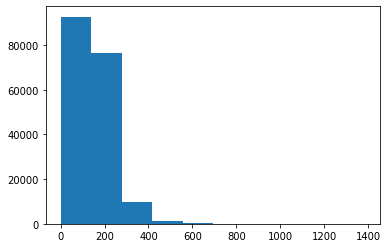

In [242]:
# Check the distribution of lens of chars in a sentence
plt.hist(char_lens);

In [243]:
# Find what charecter length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [244]:
# Get all keyboard charecters
import string
allkeys = string.ascii_lowercase + string.digits

In [245]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(allkeys) + 2 # add 2 for space and OOV (out of vocab) aka UKN
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [246]:
# Adapt charecter vectorizer to training charecter
char_vectorizer.adapt(train_chars)

In [247]:
# Check charecter voacb specs
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different charecters in charecter vocab: {len(char_vocab)}')
print(f'5 most common charecters: {char_vocab[:5]}')
print(f'5 least common charecters: {char_vocab[-5:]}')

Number of different charecters in charecter vocab: 28
5 most common charecters: ['', '[UNK]', 'e', 't', 'i']
5 least common charecters: ['k', 'x', 'z', 'q', 'j']


In [248]:
# Test our charecter vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized char - {len(vectorized_chars[0])}')

Charified text:
 s u i t a b l e   p a t i e n t s   w e r e   r a n d o m i z e d   t o   e i t h e r   r o u t i n e   o r   s e l e c t i v e   p r e o p e r a t i v e   u l t r a s o u n d   i m a g i n g   ;   s e l e c t i v e   i m a g i n g   w a s   p e r f o r m e d   o n l y   w h e n   c l i n i c a l   c r i t e r i a   w e r e   n o t   m e t   .
Length of random_train_chars: 149

Vectorized chars:
 [[ 9 16  4  3  5 22 12  2 14  5  3  4  2  6  3  9 20  2  8  2  8  5  6 10
   7 15  4 25  2 10  3  7  2  4  3 13  2  8  8  7 16  3  4  6  2  7  8  9
   2 12  2 11  3  4 21  2 14  8  2  7 14  2  8  5  3  4 21  2 16 12  3  8
   5  9  7 16  6 10  4 15  5 18  4  6 18  9  2 12  2 11  3  4 21  2  4 15
   5 18  4  6 18 20  5  9 14  2  8 17  7  8 15  2 10  7  6 12 19 20 13  2
   6 11 12  4  6  4 11  5 12 11  8  4  3  2  8  4  5 20  2  8  2  6  7  3
  15  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating charecter-level embedding

In [249]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name='char_embedding_layer')

In [250]:
# Text our charecter embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer(random_train_chars))
print(f'Embedded chars {char_embed_example}')
print(f'\nCharecter embedding shape: {char_embed_example.shape}')

Charified text:
 s u i t a b l e   p a t i e n t s   w e r e   r a n d o m i z e d   t o   e i t h e r   r o u t i n e   o r   s e l e c t i v e   p r e o p e r a t i v e   u l t r a s o u n d   i m a g i n g   ;   s e l e c t i v e   i m a g i n g   w a s   p e r f o r m e d   o n l y   w h e n   c l i n i c a l   c r i t e r i a   w e r e   n o t   m e t   .

Embedded chars [[ 3.6073375e-02  3.7955765e-02  7.1247816e-03 ... -8.1102364e-03
  -4.2058490e-02  3.2826249e-02]
 [-2.0150006e-02 -1.5074126e-03  6.8154559e-03 ...  3.8583908e-02
   4.0841829e-02  5.5729374e-03]
 [-3.9154135e-02 -1.2936652e-02 -1.9693494e-02 ...  4.4709954e-02
   2.7584348e-02 -1.2222182e-02]
 ...
 [-9.5941126e-05  9.8660216e-03 -1.2754500e-02 ...  3.7695516e-02
   3.8190596e-03 -3.7344992e-02]
 [-9.5941126e-05  9.8660216e-03 -1.2754500e-02 ...  3.7695516e-02
   3.8190596e-03 -3.7344992e-02]
 [-9.5941126e-05  9.8660216e-03 -1.2754500e-02 ...  3.7695516e-02
   3.8190596e-03 -3.7344992e-02]]

Charecter embedding 

## Building a Conv1D model to fit on charecter embeddings

In [251]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1, ), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu') (char_embeddings)
x = layers.GlobalMaxPooling1D() (x)
outputs = layers.Dense(num_classes, activation='softmax') (x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3_conv1d_char_embeddings')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [252]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding_layer (Embed  (None, 290, 25)          700       
 ding)                                                           
                                                                 
 conv1d_5 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                    

In [253]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [254]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.2 * len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.2 * len(val_char_dataset)))

Epoch 1/3
1125/1125 [==============================] - 8s 6ms/step - loss: 1.1454 - accuracy: 0.5316 - val_loss: 0.9815 - val_accuracy: 0.6075
Epoch 2/3
1125/1125 [==============================] - 7s 7ms/step - loss: 0.9281 - accuracy: 0.6339 - val_loss: 0.8801 - val_accuracy: 0.6558
Epoch 3/3
1125/1125 [==============================] - 7s 6ms/step - loss: 0.8677 - accuracy: 0.6612 - val_loss: 0.8166 - val_accuracy: 0.6878


In [255]:
# Make predictions with charecter model only
model_3_pred_probs = model_3.predict(val_char_dataset)

945/945 [==============================] - 3s 3ms/step


In [256]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

In [257]:
# Calculate results for Conv1D model chars only 
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 68.59526016152522,
 'precision': 0.676409153930657,
 'recall': 0.6859526016152522,
 'f1': 0.6767120768054745}

## Model 4: Combining pretrained token embeddings + charecter embeddings (hybrid embedding layer)

> 1. Create a token-level embedding model (similar to `model_1`)
> 2. Create a charecter-level model (similar to `model_3` with a slight modification)
> 3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
> 4. Build a series of output layers on top of layer 3
> 5. Construct a model that takes token and charecter-level sequences as input and produces sequence label probabilities as output.

In [286]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu') (token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)


char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24)) (char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


token_char_concat = layers.Concatenate(name='token_char_hybrid') ([token_model.output,
                                                                   char_model.output])

combined_dropout = layers.Dropout(0.5) (token_char_concat)
combined_dense = layers.Dense(128, activation='relu') (combined_dropout)
final_dropout = layers.Dropout(0.5) (combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax') (final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [287]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

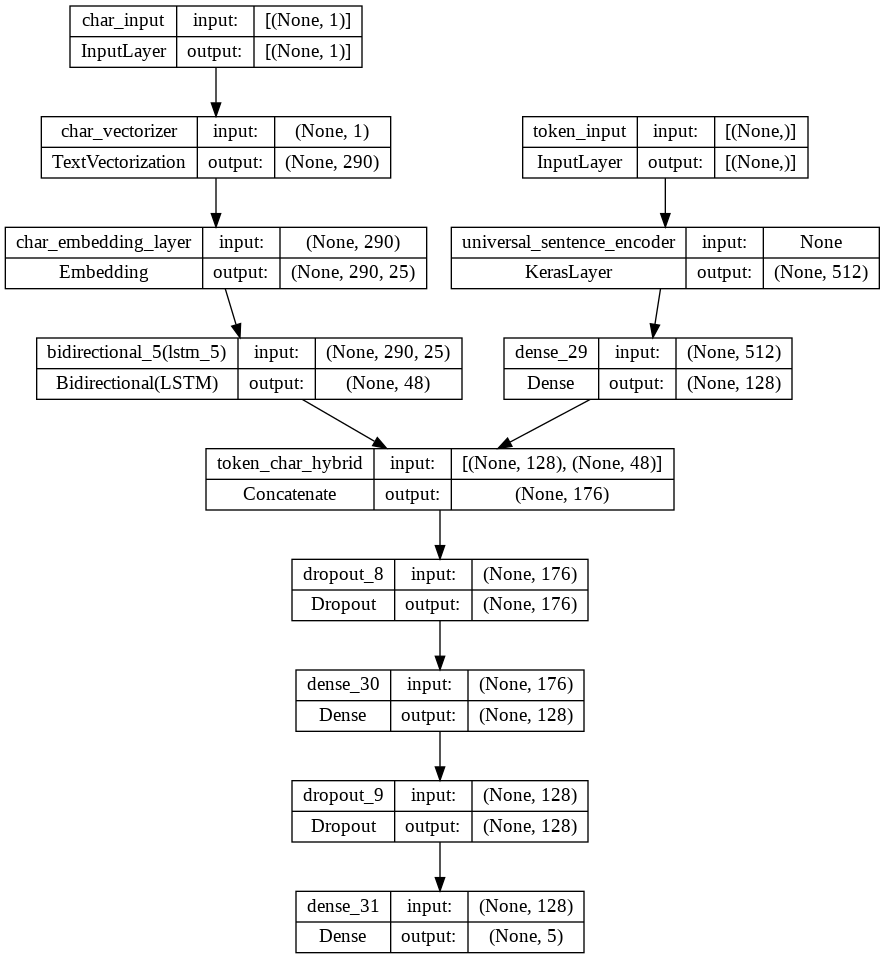

In [288]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [290]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and charecter data into a tf.data Dataset

In [291]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fitting a model on token and char-level sequences

In [292]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 58ms/step - loss: 0.9773 - accuracy: 0.6100 - val_loss: 0.7625 - val_accuracy: 0.7045
Epoch 2/3
562/562 [==============================] - 31s 55ms/step - loss: 0.7934 - accuracy: 0.6976 - val_loss: 0.7074 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 28s 51ms/step - loss: 0.7718 - accuracy: 0.7075 - val_loss: 0.6854 - val_accuracy: 0.7430


In [293]:
# model 4 preds
model_4_pred_probs = model_4.predict(val_char_token_dataset, verbose=1)
model_4_pred_probs

945/945 [==============================] - 28s 25ms/step


array([[4.9005398e-01, 3.0344391e-01, 3.8259588e-03, 1.9746800e-01,
        5.2081863e-03],
       [3.4761298e-01, 5.1181352e-01, 2.2087877e-03, 1.3699929e-01,
        1.3653854e-03],
       [3.4782717e-01, 1.8444481e-01, 5.4985169e-02, 3.6373460e-01,
        4.9008287e-02],
       ...,
       [4.8549109e-04, 8.2672685e-03, 7.0187189e-02, 2.1438886e-04,
        9.2084575e-01],
       [5.9963502e-03, 5.0854940e-02, 2.3744033e-01, 3.0679957e-03,
        7.0264041e-01],
       [2.9466197e-01, 4.2006201e-01, 1.8612497e-01, 5.2566763e-02,
        4.6584293e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [295]:
# Calculate results of token-char-positional hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.78525089368463,
 'precision': 0.7368585476393517,
 'recall': 0.7378525089368463,
 'f1': 0.7341849520433888}

{'accuracy': 73.78525089368463,
 'precision': 0.7368585476393517,
 'recall': 0.7378525089368463,
 'f1': 0.7341849520433888}

## Model 5: Pretrained token embeddings + character embeddings + positional embeddings

The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

In [267]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

Since the "line_number" and "total_line" columns are already numerical, we could pass them as they are to our model.

In [268]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

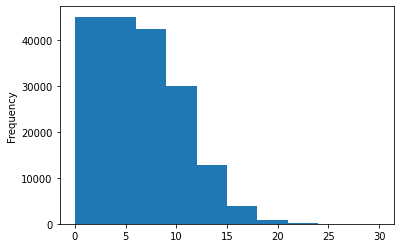

In [269]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this we can set the depth parameter of tf.one_hot to 15.

In [270]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [271]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

We could do the same thing for number of lines as well.

In [272]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

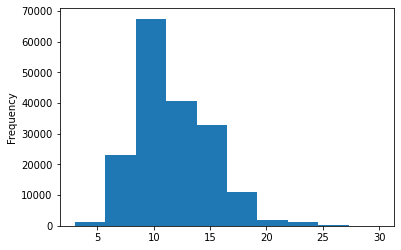

In [273]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

In [274]:
# Check how many number of lines covers 98 percentile
np.percentile(train_df.total_lines, 98) 

20.0

In [275]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

In [276]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [277]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

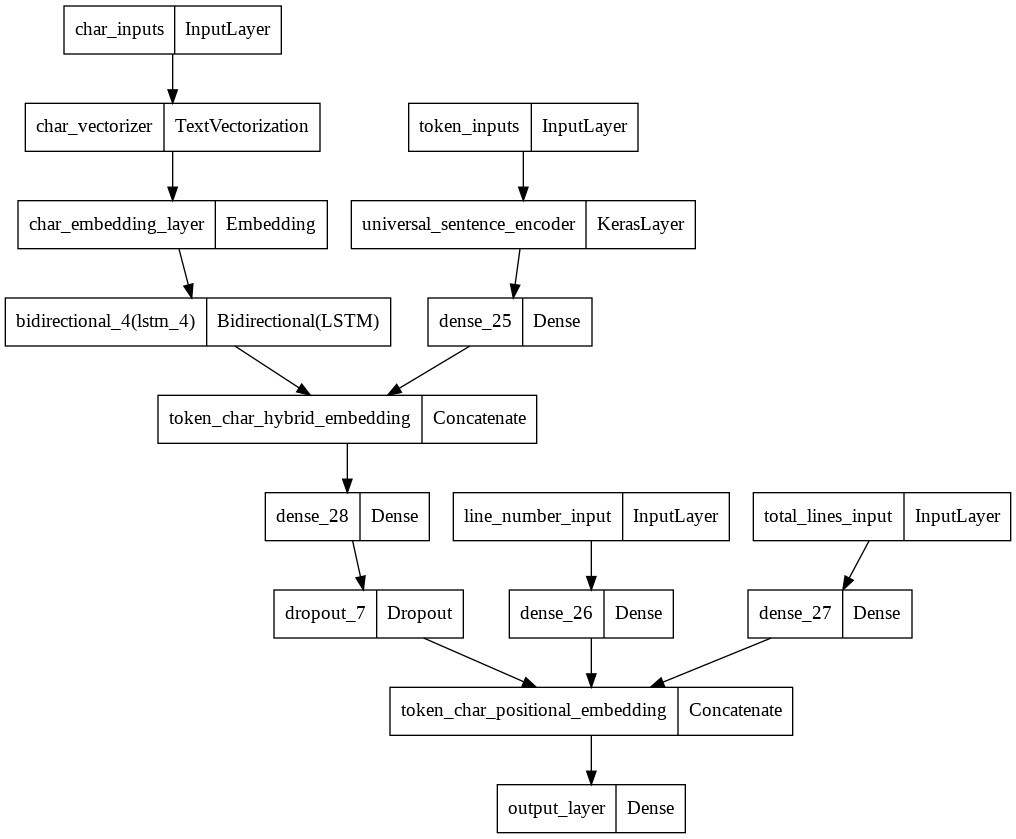

In [278]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

Now our model is constructed, time compile it.

In [279]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # reduce initial confidence of the model
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model

Our model requires four feature inputs:

1. Train line numbers one-hot tensor (train_line_numbers_one_hot)
2. Train total lines one-hot tensor (train_total_lines_one_hot)
3. Token-level sequences tensor (train_sentences)
4. Char-level sequences tensor (train_chars)

In [280]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch
# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [281]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 59ms/step - loss: 1.0917 - accuracy: 0.7291 - val_loss: 0.9813 - val_accuracy: 0.8025
Epoch 2/3
562/562 [==============================] - 30s 54ms/step - loss: 0.9671 - accuracy: 0.8155 - val_loss: 0.9483 - val_accuracy: 0.8258
Epoch 3/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9490 - accuracy: 0.8257 - val_loss: 0.9360 - val_accuracy: 0.8314


In [282]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 28s 26ms/step


array([[0.50996226, 0.10853603, 0.00924563, 0.35522994, 0.01702615],
       [0.5799054 , 0.08452451, 0.05452335, 0.26975167, 0.0112951 ],
       [0.30068728, 0.11598507, 0.12851621, 0.3933792 , 0.0614322 ],
       ...,
       [0.03540006, 0.1068294 , 0.04549045, 0.027713  , 0.78456706],
       [0.02697627, 0.28894907, 0.07547948, 0.02320776, 0.5853874 ],
       [0.20916653, 0.5650508 , 0.10472104, 0.04847969, 0.07258203]],
      dtype=float32)

In [283]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [284]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.38408579372435,
 'precision': 0.8327720708940219,
 'recall': 0.8338408579372435,
 'f1': 0.832492219368685}

## Compare model results

In [296]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.475440,0.781585,0.784754,0.782559
pretrained_token_embed,73.705812,0.731460,0.737058,0.732903
custom_char_embed_conv1d,68.595260,0.676409,0.685953,0.676712
hybrid_char_token_embed,73.785251,0.736859,0.737853,0.734185
tribrid_pos_char_token_embed,83.384086,0.832772,0.833841,0.832492


In [297]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

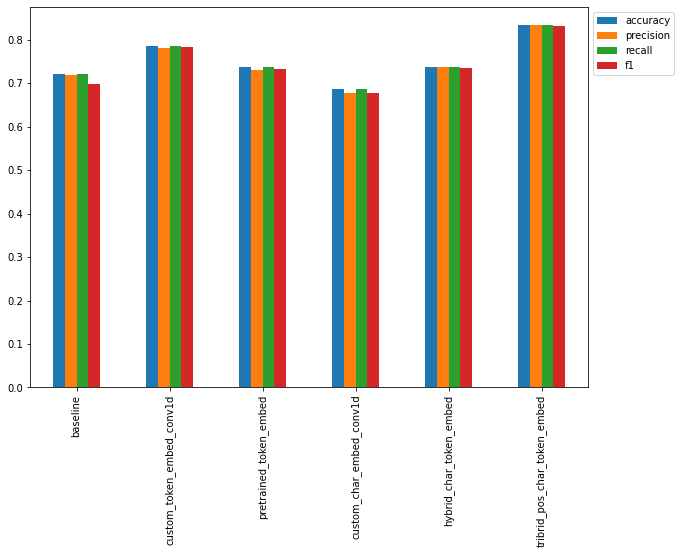

In [298]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

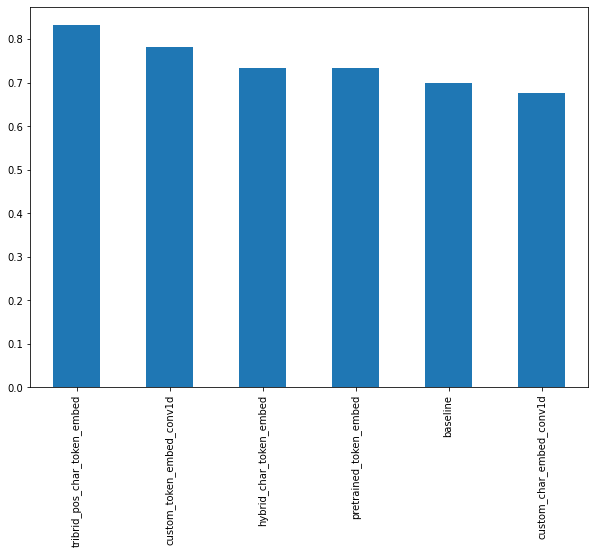

In [299]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [306]:
import json
# open an example abstract to classify that the model has never seen before
!wget https://raw.githubusercontent.com/bharathithal/EasySkim/main/example_abstract.json

with open("example_abstract.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2022-11-27 18:07:38--  https://raw.githubusercontent.com/bharathithal/EasySkim/main/example_abstract.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘example_abstract.json’

example_abstract.js 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-11-27 18:07:38 (55.8 MB/s) - ‘example_abstract.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [307]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [310]:
# Create sentencizer
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.create_pipe("sentencizer") 
nlp.add_pipe('sentencizer')
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [312]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [313]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [314]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [315]:
# Make predictions on sample abstract features
test_abstract_pred_probs = model_2_pred_probs

In [316]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [317]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'RESULTS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'RESULTS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS'

In [318]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
CONCLUSIONS: Participants were randomly assigned to treatment or wait-list conditions.
OBJECTIVE: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
METHODS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
METHODS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
